### import module

In [145]:
import time
import os, sys
import csv
from os.path import join, dirname
from operator import itemgetter
import pandas as pd
import numpy as np
from glob import glob 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale

import seaborn as sns
from matplotlib import pyplot as plt

### Global parameter

In [146]:
feat_norm = 0          # feature normalization
target_idx=0           #Index of Target variable
cross_val=1            #Control Switch for CV                                                                                                                                                      
norm_target=0          #Normalize target switch
norm_features=0        #Normalize target switch
binning=1              #Control Switch for Bin Target
bin_cnt=2              #If bin target, this sets number of classes
feat_select=1          #Control Switch for Feature Selection
fs_type=3              #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)                        
feat_start=0           #Start column of features
k_cnt=5                #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3

rand_st=1

### Load Data

In [147]:
root_dir = '/workspace/GradSchool/2020-2/Adv_ML/Final/data/processed_data'

train_stat_file = root_dir + '/train_stat.csv'
train_result_file = root_dir + '/EPL_Results_from_2014_to_2019.csv'
test_stat_file = root_dir + '/test_stat.csv'
test_result_file = root_dir + '/EPL_Result_2019-20.csv'

train_stat = pd.read_csv(train_stat_file)
train_result = pd.read_csv(train_result_file)
test_stat = pd.read_csv(test_stat_file)
test_result = pd.read_csv(test_result_file)

stat_col = list(train_stat.columns)
result_col = list(train_result.columns)

### Prepare data

In [148]:
col_list = ['Appearances', 'Clean sheets', 'Goals conceded', 'Tackles', 'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance','Clearances off line', 'Recoveries', 'Duels won', 'Duels lost', 'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists', 'Passes per match', 'Big chances created', 'Crosses', 'Through balls', 'Accurate long balls', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Hit woodwork', 'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 'Big chances missed', 'Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks', 'minutes_played']

In [149]:
# prepare classification
train_result.loc[(train_result.FTR == 'H'),'FTR'] = 1
train_result.loc[(train_result.FTR == 'D'),'FTR'] = 0
train_result.loc[(train_result.FTR == 'A'),'FTR'] = -1

test_result.loc[(test_result.FTR == 'H'),'FTR'] = 1
test_result.loc[(test_result.FTR == 'D'),'FTR'] = 0
test_result.loc[(test_result.FTR == 'A'),'FTR'] = -1

In [150]:
train_result.rename(columns={'FTHG': 'Home_score'}, inplace=True)
train_result.rename(columns={'FTAG': 'Away_score'}, inplace=True)
train_result.rename(columns={'FTR': 'target'}, inplace=True)

test_result.rename(columns={'FTHG': 'Home_score'}, inplace=True)
test_result.rename(columns={'FTAG': 'Away_score'}, inplace=True)
test_result.rename(columns={'FTR': 'target'}, inplace=True)

In [151]:
if feat_norm:
    for col in col_list:
        train_stat[col] = scale(train_stat[col])
        test_stat[col] = scale(test_stat[col])

In [152]:
def sum_stat(data, column_list, num, is_team = False):
    value = []
    
    if is_team:
        for i in column_list:
            value.append(data[i].sum())
    else:
        for i in column_list:
            value.append(data[i].sum() / len(data) * 3)
    
    return value

In [153]:
def cal_lineup_value(data, team, formation = [4,3,3]):
    # data: players stat data list, season: str, team:list, formation: list
    season = str(team[0])
    name = str(team[1])
    
    team_mem = data[data['teams_played_for'] == name]
    team_mem = team_mem[team_mem['Season'] == season]
    
    col = ['Appearances', 'Clean sheets', 'Goals conceded', 'Tackles', 'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance','Clearances off line', 'Recoveries', 'Duels won', 'Duels lost', 'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists', 'Passes per match', 'Big chances created', 'Crosses', 'Through balls', 'Accurate long balls', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Hit woodwork', 'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 'Big chances missed', 'Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks', 'minutes_played']
    
    gk_num = 1
    df_num = formation[0]
    mf_num = formation[1]
    fw_num = formation[2]
    
    team_value = pd.DataFrame(columns=col)
    temp_team_value = pd.DataFrame(columns=col)
    
    gk = team_mem[team_mem['Position'] == 'Goalkeeper']    
    df = team_mem[team_mem['Position'] == 'Defender']
    mf = team_mem[team_mem['Position'] == 'Midfielder']
    fw = team_mem[team_mem['Position'] == 'Forward']
    
    # calculate each position's value
    team_gk_value = sum_stat(gk, col,gk_num)
    team_df_value = sum_stat(df, col, df_num)
    team_mf_value = sum_stat(mf, col, mf_num)
    team_fw_value = sum_stat(fw, col, fw_num)
    
    # calculate 11 player's value
    temp_team_value.loc[0] = team_gk_value
    temp_team_value.loc[1] = team_df_value
    temp_team_value.loc[2] = team_mf_value
    temp_team_value.loc[3] = team_fw_value
    
    team_value.loc[0] = sum_stat(temp_team_value, col, 0, is_team=True)
    team_info = pd.DataFrame({'Season': [season], 'Team_name': [name]})
    team_value = pd.concat([team_info, team_value], axis=1)
    
    return team_value

In [154]:
team_participate = pd.read_csv(root_dir+'/participation_team.csv')

In [155]:
is_train = team_participate['Season'].str.contains('2015-16|2016-17|2017-18|2018-19')
is_test = team_participate['Season'].str.contains('2019-20')

In [156]:
train_team_participate = np.asarray(team_participate[is_train])
test_team_participate = np.asarray(team_participate[is_test])

In [157]:
team_stat_col = ['Season', 'Team_name', 'Appearances', 'Clean sheets', 'Goals conceded', 'Tackles', 'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance','Clearances off line', 'Recoveries', 'Duels won', 'Duels lost', 'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists', 'Passes per match', 'Big chances created', 'Crosses', 'Through balls', 'Accurate long balls', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Hit woodwork', 'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 'Big chances missed', 'Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks', 'minutes_played']

In [158]:
train_team_stat = pd.DataFrame(columns=team_stat_col)
test_team_stat = pd.DataFrame(columns=team_stat_col)

In [159]:
for num in range(len(train_team_participate)):
    temp_team_stat = cal_lineup_value(train_stat, train_team_participate[num])
    train_team_stat = pd.concat([train_team_stat, temp_team_stat])

In [160]:
for num in range(len(test_team_participate)):
    temp_team_stat = cal_lineup_value(test_stat, test_team_participate[num])
    test_team_stat = pd.concat([test_team_stat, temp_team_stat])

<ipython-input-152-4ae42a1309cf>:9: RuntimeWarning: invalid value encountered in longlong_scalars
  value.append(data[i].sum() / len(data) * 3)
<ipython-input-152-4ae42a1309cf>:9: RuntimeWarning: invalid value encountered in double_scalars
  value.append(data[i].sum() / len(data) * 3)


In [161]:
train_team_stat = train_team_stat[['Season', 'Team_name', 'Clean sheets', 'Goals conceded', 'Tackles', 'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance','Clearances off line', 'Recoveries', 'Duels won', 'Duels lost', 'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists', 'Passes per match', 'Big chances created', 'Crosses', 'Through balls', 'Accurate long balls', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Hit woodwork', 'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 'Big chances missed', 'Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks']]

In [162]:
test_team_stat = test_team_stat[['Season', 'Team_name', 'Clean sheets', 'Goals conceded', 'Tackles', 'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance','Clearances off line', 'Recoveries', 'Duels won', 'Duels lost', 'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists', 'Passes per match', 'Big chances created', 'Crosses', 'Through balls', 'Accurate long balls', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Hit woodwork', 'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 'Big chances missed', 'Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks']]

In [163]:
result_col = ['Season', 'HomeTeam', 'AwayTeam', 'Home_score', 'Away_score', 'target']
Home_col = ['Home_Clean sheets', 'Home_Goals conceded', 'Home_Tackles', 'Home_Last man tackles', 'Home_Blocked shots', 'Home_Interceptions', 'Home_Clearances', 'Home_Headed Clearance','Home_Clearances off line', 'Home_Recoveries', 'Home_Duels won', 'Home_Duels lost', 'Home_Successful 50/50s', 'Home_Aerial battles won', 'Home_Aerial battles lost', 'Home_Own goals', 'Home_Errors leading to goal', 'Home_Assists', 'Home_Passes per match', 'Home_Big chances created', 'Home_Crosses', 'Home_Through balls', 'Home_Accurate long balls', 'Home_Yellow cards', 'Home_Red cards', 'Home_Fouls', 'Home_Offsides', 'Home_Hit woodwork', 'Home_Goals per match', 'Home_Penalties scored', 'Home_Freekicks scored', 'Home_Shots', 'Home_Shots on target', 'Home_Big chances missed', 'Home_Saves', 'Home_Penalties saved', 'Home_Punches', 'Home_High Claims', 'Home_Catches', 'Home_Sweeper clearances', 'Home_Throw outs', 'Home_Goal Kicks']
Away_col = ['Away_Clean sheets', 'Away_Goals conceded', 'Away_Tackles', 'Away_Last man tackles', 'Away_Blocked shots', 'Away_Interceptions', 'Away_Clearances', 'Away_Headed Clearance','Away_Clearances off line', 'Away_Recoveries', 'Away_Duels won', 'Away_Duels lost', 'Away_Successful 50/50s', 'Away_Aerial battles won', 'Away_Aerial battles lost', 'Away_Own goals', 'Away_Errors leading to goal', 'Away_Assists', 'Away_Passes per match', 'Away_Big chances created', 'Away_Crosses', 'Away_Through balls', 'Away_Accurate long balls', 'Away_Yellow cards', 'Away_Red cards', 'Away_Fouls', 'Away_Offsides', 'Away_Hit woodwork', 'Away_Goals per match', 'Away_Penalties scored', 'Away_Freekicks scored', 'Away_Shots', 'Away_Shots on target', 'Away_Big chances missed', 'Away_Saves', 'Away_Penalties saved', 'Away_Punches', 'Away_High Claims', 'Away_Catches', 'Away_Sweeper clearances', 'Away_Throw outs', 'Away_Goal Kicks']
final_data_col = result_col + Home_col + Away_col

train = pd.DataFrame(columns=final_data_col)
test = pd.DataFrame(columns=final_data_col)

In [164]:
temp_train = []

for i in range(len(train_result)):
    
    season = train_result.loc[i]['Season']
    home = train_result.loc[i]['HomeTeam']
    away = train_result.loc[i]['AwayTeam']
    
    home_stat = train_team_stat[(train_team_stat['Season'] == season) & (train_team_stat['Team_name'] == home)]
    home_stat = list(home_stat.iloc[0])
    away_stat = train_team_stat[(train_team_stat['Season'] == season) & (train_team_stat['Team_name'] == away)]
    away_stat = list(away_stat.iloc[0])
    
    match_data = list(train_result.loc[i])
    match_data += home_stat[2:]
    match_data += away_stat[2:]
    temp_train.append(match_data)

temp_train = pd.DataFrame(temp_train, columns=final_data_col)
train = pd.concat([test, temp_train])

In [165]:
temp_test = []

for i in range(len(test_result)):
    
    season = test_result.loc[i]['Season']
    home = test_result.loc[i]['HomeTeam']
    away = test_result.loc[i]['AwayTeam']
    
    home_stat = test_team_stat[(test_team_stat['Season'] == season) & (test_team_stat['Team_name'] == home)]
    home_stat = list(home_stat.iloc[0])
    away_stat = test_team_stat[(test_team_stat['Season'] == season) & (test_team_stat['Team_name'] == away)]
    away_stat = list(away_stat.iloc[0])
    
    match_data = list(test_result.loc[i])
    match_data += home_stat[2:]
    match_data += away_stat[2:]
    temp_test.append(match_data)

temp_test = pd.DataFrame(temp_test, columns=final_data_col)
test = pd.concat([test, temp_test])

In [166]:
total_data = pd.DataFrame(columns=final_data_col)
total_data = pd.concat([total_data, train])
total_data = pd.concat([total_data, test])

### EDA

<AxesSubplot:>

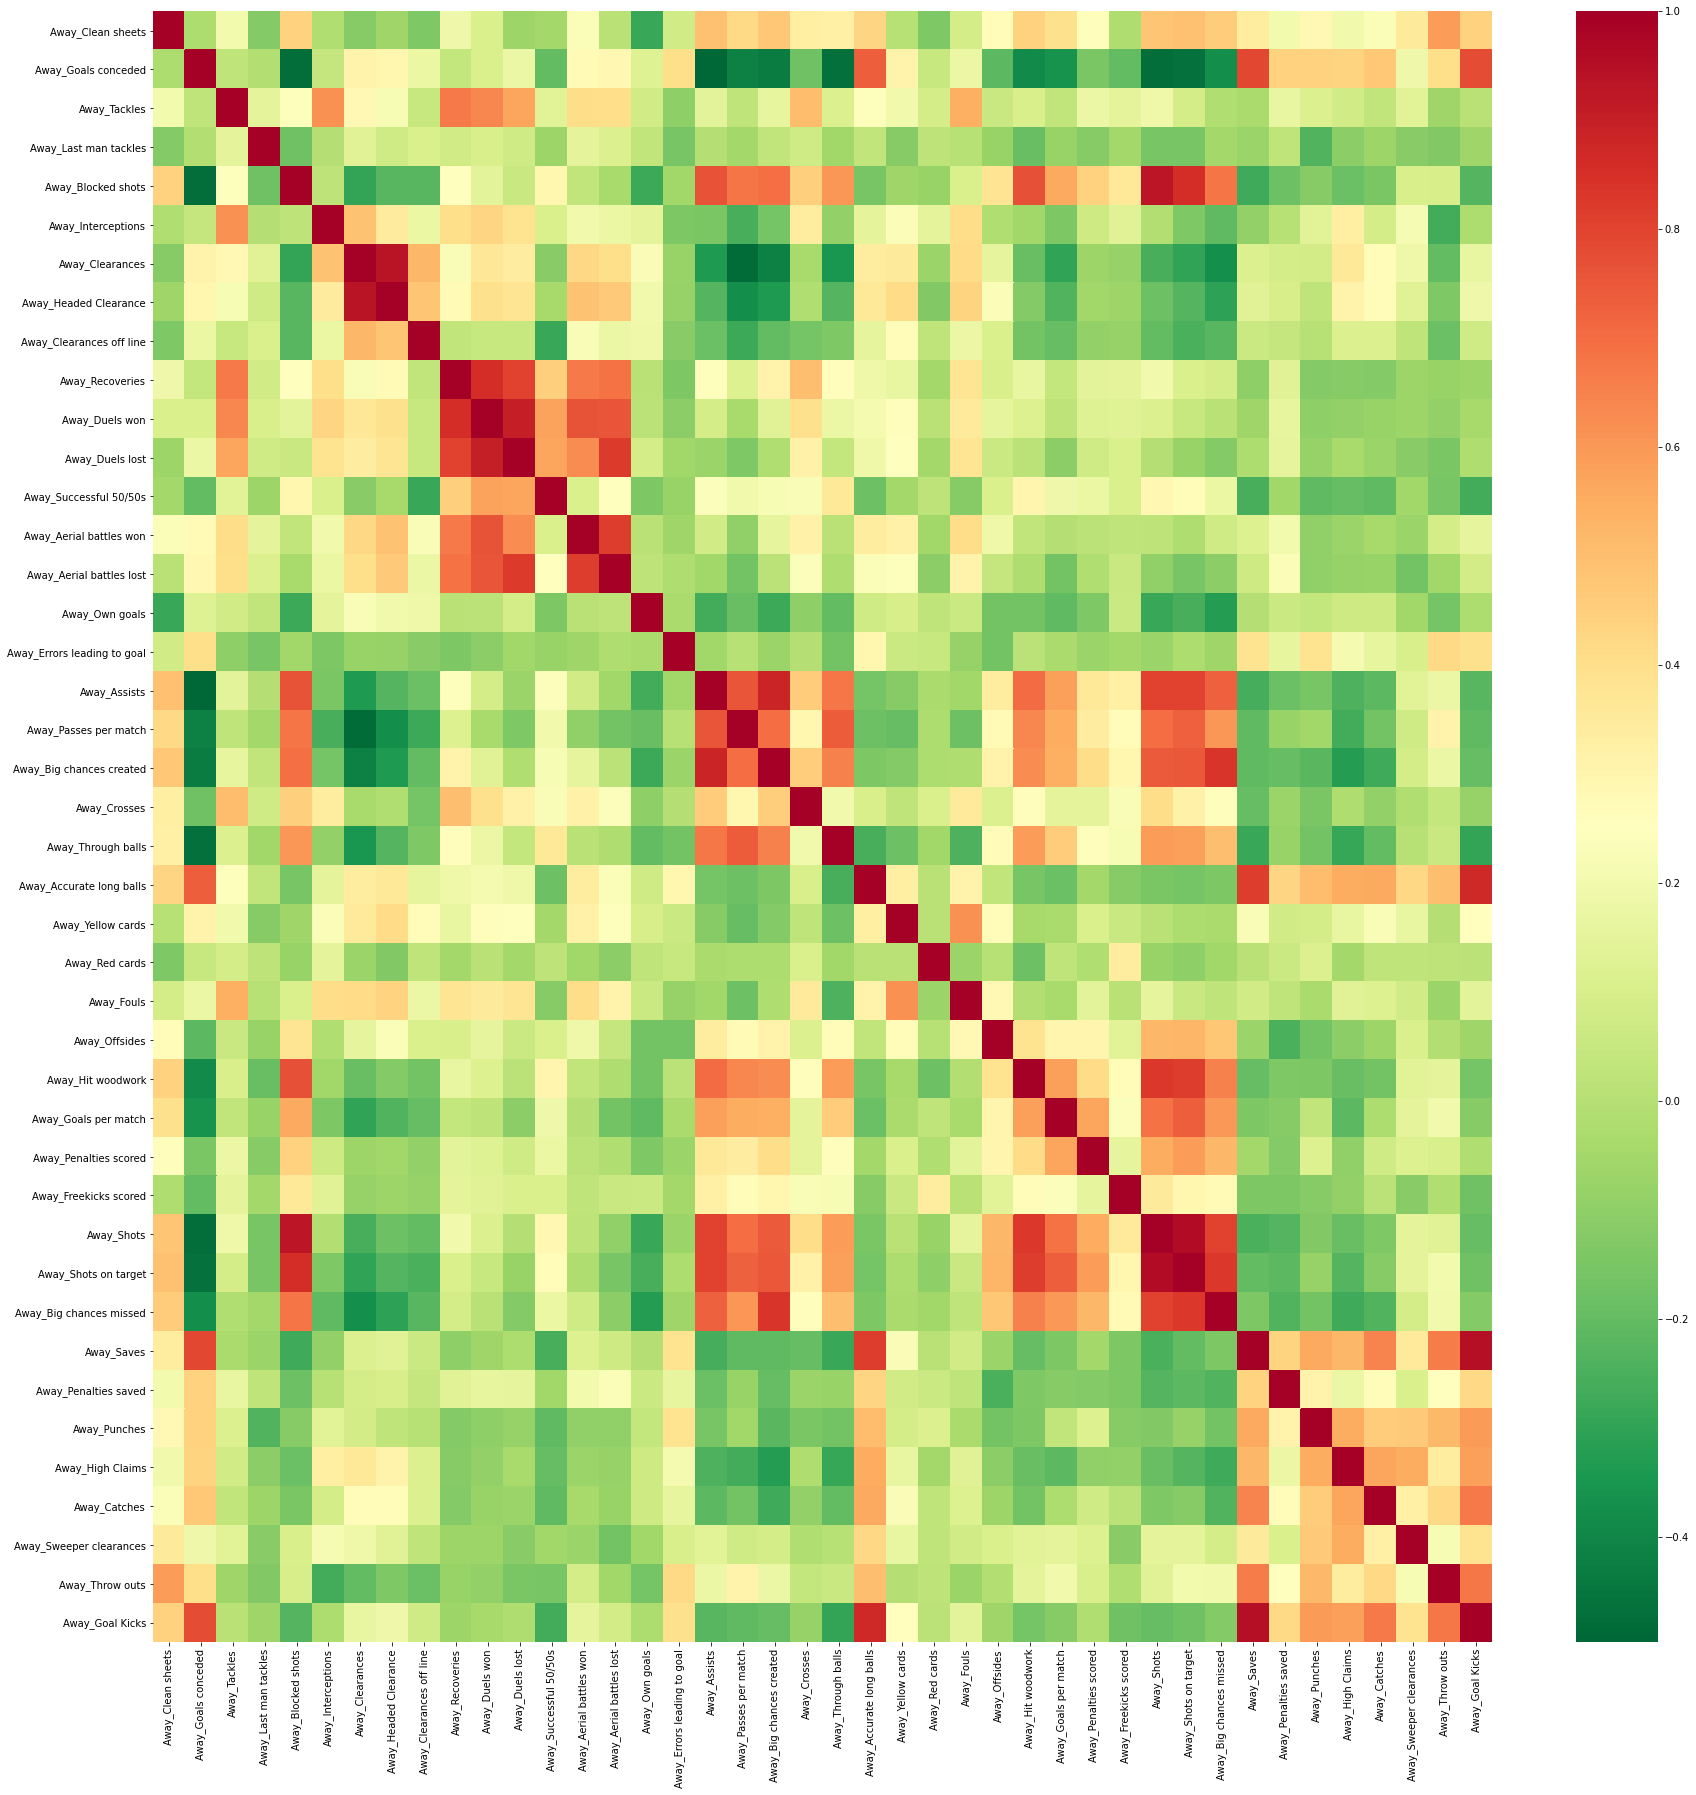

In [167]:
home_features = [ f for f in list(total_data) if 'Away_' in f ]
corr = total_data[home_features].corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, cmap='RdYlGn_r')

In order to fit our model appropriately, I have to consider an X matrix of values that has no information regarding our target variables. So, here I will drop the features that might provide the model information on y, i.e. 'Season', 'HomeTeam', 'AwayTeam', 'Home_score', and 'Away_score'.etc along with our target.

In [168]:
FEATURES_TO_DROP = ['Season', 'HomeTeam', 'AwayTeam', 'Home_score', 'Away_score', 'target', 'Away_Goals conceded', 
                    'Home_Goals conceded', 'Away_Goals per match', 'Home_Goals per match', 'Home_Freekicks scored',
                   'Away_Freekicks scored', 'Home_Penalties scored', 'Away_Penalties scored', 'Home_Assists', 'Away_Assists']
total_wo = total_data.drop(columns = FEATURES_TO_DROP)

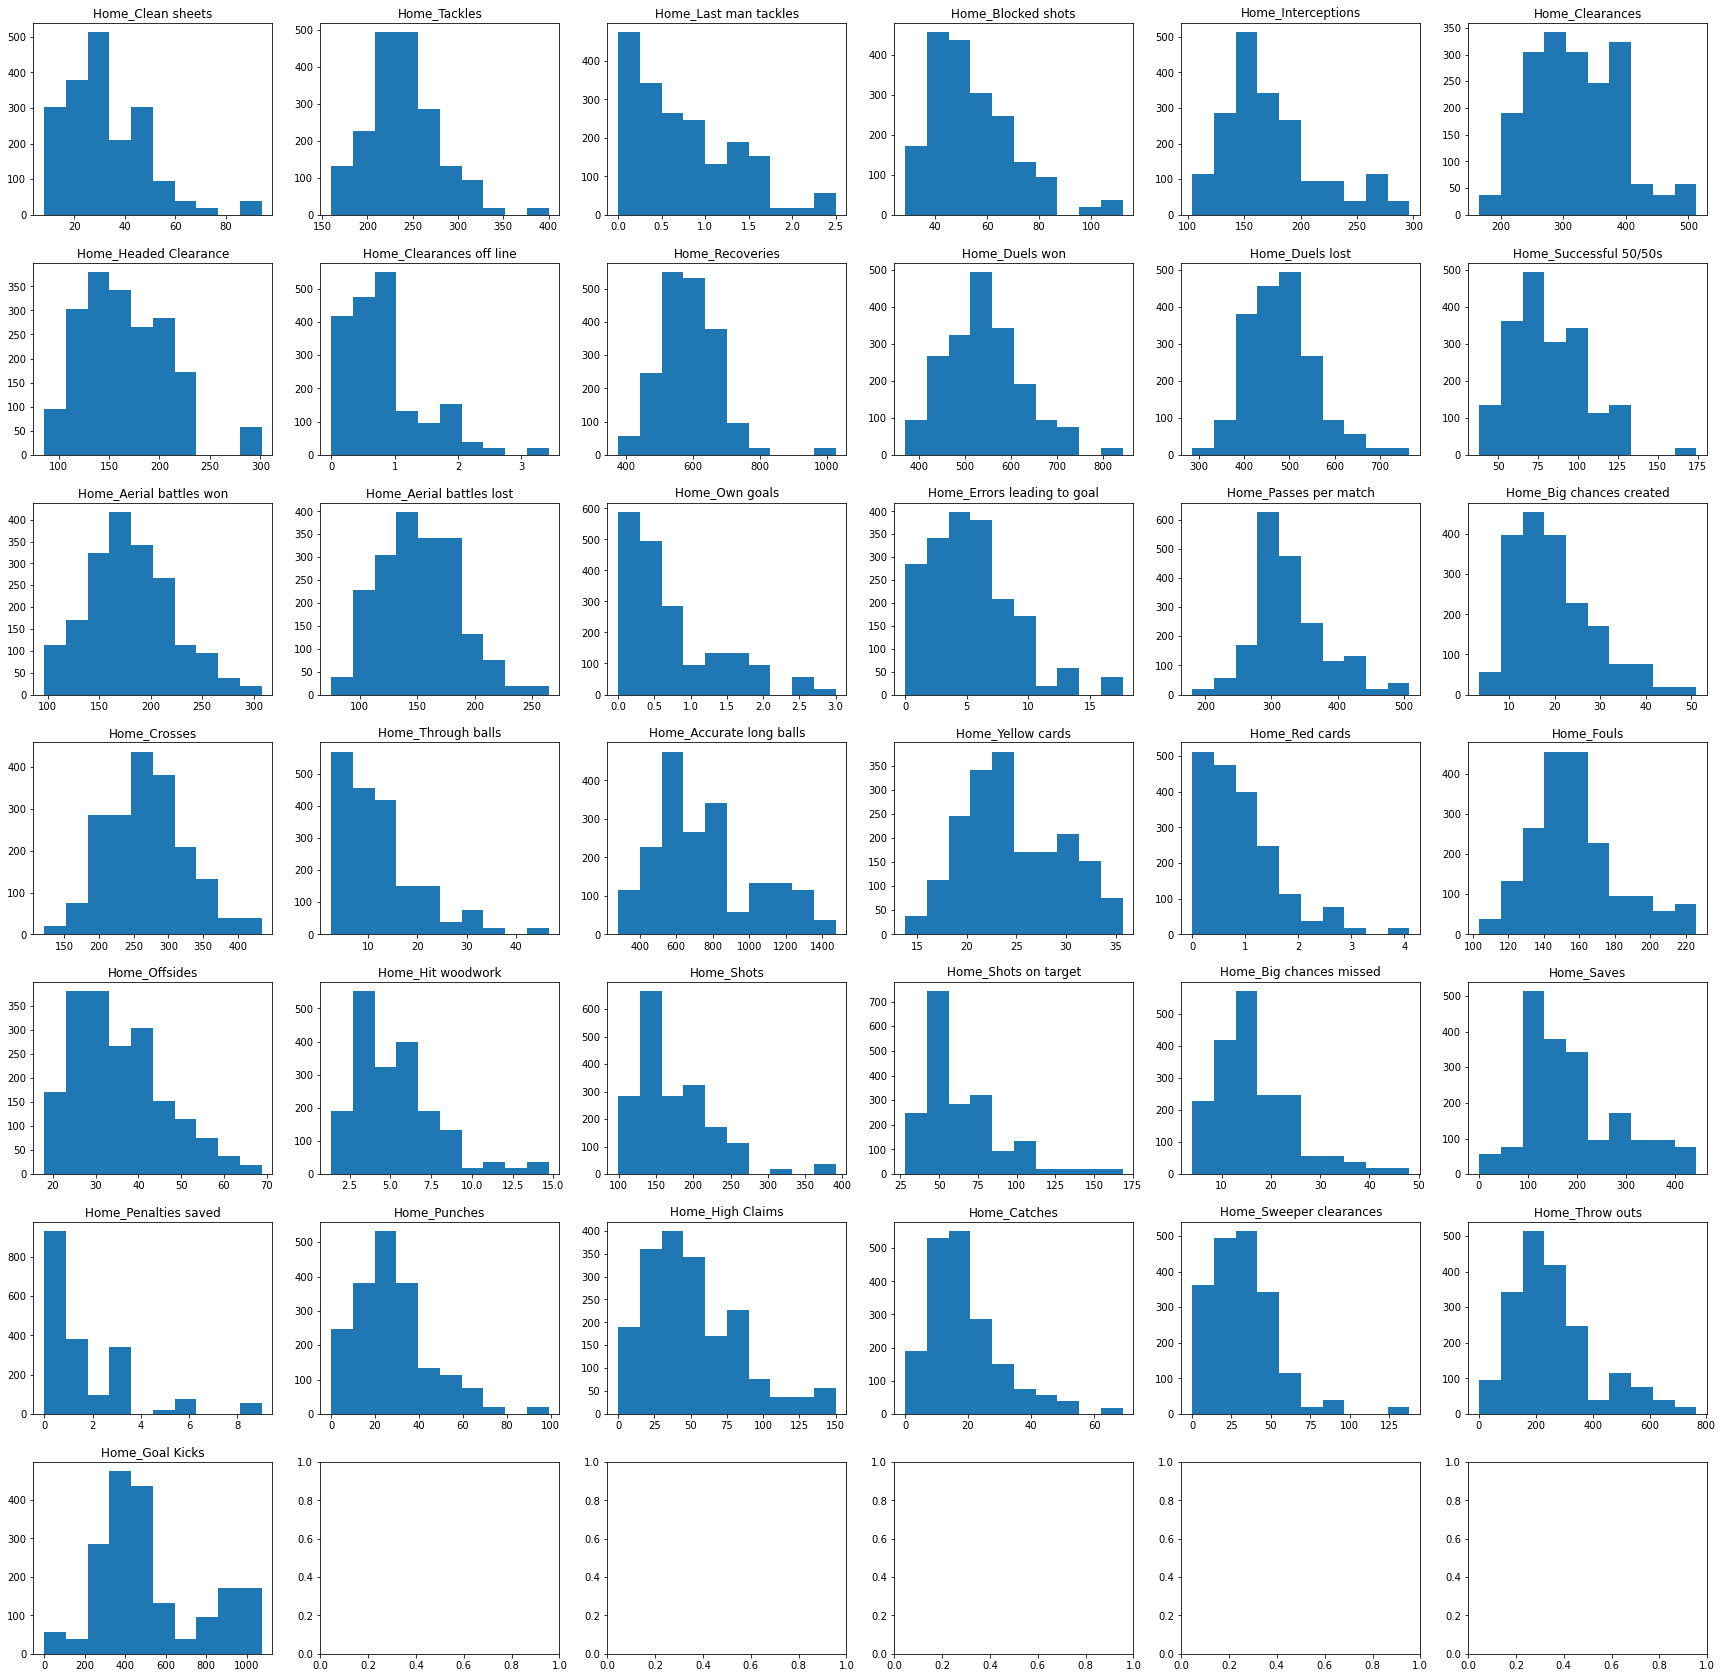

In [169]:
n_figs = len(home_features)
columns = 6

fig, axes = plt.subplots(int(n_figs/columns), columns, figsize = (30, 30))
plt.subplots_adjust(hspace = .25)

home_features = [ f for f in list(total_wo) if 'Home_' in f ]
for i, feature in enumerate(home_features):
    row = int(i / columns)
    column = i % columns
    axes[row, column].hist(total_data[feature].values)
    axes[row, column].set_title(feature)

<AxesSubplot:>

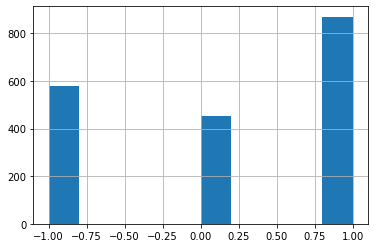

In [170]:
total_data.target.hist()

It seems to have a home advantage

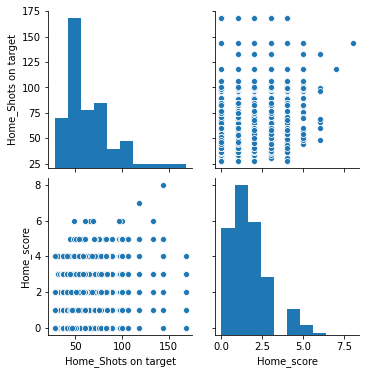

In [171]:
_ = sns.pairplot(total_data[['Home_Shots on target', 'Home_score']])

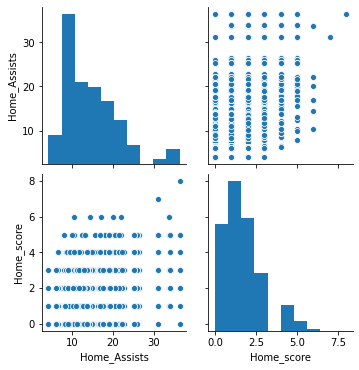

In [172]:
_ = sns.pairplot(total_data[['Home_Assists', 'Home_score']])

### Feature selection

#### Feature Importance

In [173]:
X = total_wo.values
y = total_data['target'].values
y= y.astype('int')
features = total_wo.columns
clf = RandomForestClassifier(n_estimators=500, random_state=1)

clf.fit(X, y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) Home_Passes per match          0.024319
 2) Away_Shots on target           0.023518
 3) Away_Shots                     0.021358
 4) Home_Big chances created       0.021241
 5) Home_Shots on target           0.020872
 6) Home_Blocked shots             0.019450
 7) Away_Blocked shots             0.018551
 8) Away_Clean sheets              0.018263
 9) Away_Passes per match          0.017991
10) Home_Shots                     0.017816
11) Away_Big chances created       0.017779
12) Home_Clean sheets              0.017622
13) Home_Through balls             0.017358
14) Away_Hit woodwork              0.016938
15) Away_Through balls             0.016387
16) Away_Big chances missed        0.016257
17) Home_Hit woodwork              0.016220
18) Home_Big chances missed        0.015314
19) Home_Fouls                     0.014507
20) Away_Clearances                0.013825
21) Home_Clearances                0.013675
22) Away_Offsides                  0.013555
23) Away_Tackles                

Based on this, both 'Shots on target' are an importance feature. Interestingly, both 'penalties saved' doesn't have a big impact on the match result.

In [174]:
if feat_select==1:
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')

        fit_mod=sel.fit(X, y)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = clf=GradientBoostingClassifier(n_estimators=100, loss='deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select: ')
        if binning==0:
            rgr = '''Unused in this homework'''
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select: ')

        fit_mod=sel.fit(X, y)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(X, y)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(X, y)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(features)):            
            temp.append([features[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(X[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(features[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(X[0]), len(temp))
    print('\n')

    ##3) Filter selected columns from original dataset #########
    # features = features[0:feat_start]
    # print(features)
    # for field in temp:
    #     print(field)
    #     features.append(field)
    X = np.delete(X, temp_del, axis=1)

Univariate Feature Selection - Chi2: 
Ranked Features
0 Away_Shots : 2540.225566175388
1 Home_Shots : 1936.2717579026998
2 Away_Shots on target : 1587.737383353805
3 Home_Passes per match : 1392.1537627226498
4 Home_Throw outs : 1379.500330107108
5 Away_Goal Kicks : 1358.7314271940666
6 Home_Shots on target : 1306.6922709552914
7 Away_Passes per match : 1220.0031386606543
8 Away_Throw outs : 942.8951841828012
9 Home_Goal Kicks : 905.8234375347247
10 Away_Accurate long balls : 884.0571973178165
11 Away_Saves : 812.7807644975672
12 Away_Clean sheets : 798.4485564249746
13 Home_Clean sheets : 723.8799479906172
14 Away_Blocked shots : 676.0446382589525
15 Home_Through balls : 594.3182378671695
16 Away_Big chances created : 586.3615215898112
17 Home_Big chances created : 570.385979517114
18 Away_Clearances : 567.095763596898
19 Away_Through balls : 548.8226091502227
20 Home_Blocked shots : 526.3970655277946
21 Away_Big chances missed : 507.2837678102149
22 Away_Crosses : 501.11983533631496


### Model train

I planned to use from 2015-16 to 2018-19 as train data  and 2019-20 as test data, but I decided that it was better to use cross validation for the reliability of the model and revised the plan.

In [175]:
# DecisionTree
scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'}

start_ts=time.time()
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
scores = cross_validate(clf, X, y, scoring=scorers, cv=10)

scores_Acc = scores['test_Accuracy']
print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
scores_AUC= scores['test_roc_auc']                                                                      #Only works with binary classes, not multiclass
print("Decision Tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)

Decision Tree Acc: 0.42 (+/- 0.06)
Decision Tree AUC: 0.56 (+/- 0.04)
CV Runtime: 0.08976030349731445


In [176]:
# GradientBoosting

start_ts=time.time()
clf=GradientBoostingClassifier(n_estimators=500, loss='deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
scores=cross_validate(clf, X, y, scoring=scorers, cv=10)

scores_Acc = scores['test_Accuracy']
print("Gradient Boosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))
scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass
print("Gradient Boosting AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
print("CV Runtime:", time.time()-start_ts)

Gradient Boosting Acc: 0.48 (+/- 0.08)
Gradient Boosting AUC: 0.64 (+/- 0.08)
CV Runtime: 24.423875331878662


In [177]:
# Ada Boosting

start_ts=time.time()
clf=AdaBoostClassifier(n_estimators=500, base_estimator=None, learning_rate=0.1, random_state=rand_st)
scores=cross_validate(clf, X, y, scoring=scorers, cv=10)

scores_Acc = scores['test_Accuracy']
print("Ada Boosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))
scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass
print("Ada Boosting AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
print("CV Runtime:", time.time()-start_ts)

Ada Boosting Acc: 0.55 (+/- 0.05)
Ada Boosting AUC: 0.65 (+/- 0.06)
CV Runtime: 9.085722208023071


In [178]:
# Random Forest

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
scores = cross_validate(clf, X, y, scoring=scorers, cv=10)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))
scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
print("CV Runtime:", time.time()-start_ts)

Random Forest Acc: 0.49 (+/- 0.08)
Random Forest AUC: 0.64 (+/- 0.07)
CV Runtime: 15.20137333869934


In [179]:
# SVM 
start_ts=time.time()
clf=SVC(kernel='linear', gamma='scale', C=1.0, probability=True, random_state=rand_st)
scores=cross_validate(clf, X, y, scoring=scorers, cv=10)

scores_Acc = scores['test_Accuracy']                                                                                                                                    
print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
scores_AUC= scores['test_roc_auc']                                                              
print("SVM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)

SVM Acc: 0.54 (+/- 0.05)
SVM AUC: 0.66 (+/- 0.05)
CV Runtime: 1919.5100448131561


In [180]:
# MLP

start_ts=time.time()
clf=MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(clf, X, y, scoring=scorers, cv=10)

scores_Acc = scores['test_Accuracy']
print("MLPClassifier Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))
scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass
print("MLPClassifier AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
print("CV Runtime:", time.time()-start_ts)

MLPClassifier Acc: 0.53 (+/- 0.07)
MLPClassifier AUC: 0.65 (+/- 0.07)
CV Runtime: 5.295860290527344
